<a href="https://colab.research.google.com/github/HappyJJins/Jeju_CreditCard/blob/master/DataExploring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 목차

I. 데이터 준비  
&nbsp;(1) 랜덤 샘플 10000개 추출  

II. 데이터 전처리  
&nbsp;(1) 날짜 데이터 전처리  
&nbsp;(2) 지역민과 관광객으로 나누기  

III. 시각화  
&nbsp;(1) 인덱싱  
&nbsp;(2)지역민과 관광객 소비패턴 비교  
  
IV. 평가

In [ ]:
import os, sys
from google.colab import drive

ROOT = '/content/drive'
drive.mount(ROOT)

my_path = '/content/notebooks'
# Colab Notebooks 안에 my_env 폴더에 패키지 저장
os.symlink('/content/drive/My Drive/Colab Notebooks/my_env', my_path)
sys.path.insert(0, my_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
from os.path import join

MY_GOOGLE_DRIVE_PATH = '/content/drive/My Drive/Colab Notebooks/Jeju'
PROJECT_PATH = join(ROOT, MY_GOOGLE_DRIVE_PATH)

In [1]:
from google.colab import auth
auth.authenticate_user()

In [3]:
from google.cloud import bigquery

import pandas as pd
import numpy as np
import sklearn
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder

# 평가 메트릭
from sklearn.metrics import mean_squared_error, mean_absolute_error

# 시각화
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt  # Matlab-style plotting

# 통계
from scipy import stats
from scipy.stats import norm, skew #for some statistics

from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### I. 데이터 준비

#### (1) 랜덤 샘플 10000개 추출

In [4]:
project_id = 'jeju-282707'
client = bigquery.Client(project=project_id)

train = client.query('''
  SELECT 
      * 
  FROM `jeju-282707.jeju_data_ver1.201901_202003_train` 
  WHERE RAND() < 10000 / (SELECT COUNT(*) FROM `jeju-282707.jeju_data_ver1.201901_202003_train`)
  ''').to_dataframe()

In [ ]:
train

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,전북,익산시,체인화 편의점,강원,춘천시,20s,2,1,6,23900,7
1,201909,서울,구로구,체인화 편의점,강원,정선군,20s,2,1,5,38950,8
2,202003,강원,양양군,중식 음식점업,강원,양양군,20s,1,1,24,969000,31
3,201912,강원,춘천시,피자 햄버거 샌드위치 및 유사 음식점업,강원,홍천군,20s,1,2,3,45700,3
4,201910,경기,포천시,피자 햄버거 샌드위치 및 유사 음식점업,강원,원주시,20s,1,1,15,218400,22
...,...,...,...,...,...,...,...,...,...,...,...,...
10050,201902,충북,음성군,기타음식료품위주종합소매업,충북,괴산군,60s,1,5,18,3407190,31
10051,201904,충북,단양군,휴양콘도 운영업,충북,단양군,60s,1,5,36,1516600,49
10052,201906,충북,보은군,차량용 주유소 운영업,충북,보은군,70s,2,5,60,7910182,106
10053,201902,충북,청주시 흥덕구,과실 및 채소 소매업,충북,청주시 상당구,70s,1,5,9,462000,10


*   CARD_SIDO_NM : 카드이용지역_시도 (가맹점 주소 기준)
*   CARD_CCG_NM : 카드이용지역_시군구 (가맹점 주소 기준)
*   STD_CLSS_NM : 업종명
*   HOM_SIDO_NM : 거주지역_시도 (고객 집주소 기준)
*   HOM_CCG_NM : 거주지역_시군구 (고객 집주소 기준)
*   SEX_CTGO_CD : 성별 (1: 남성, 2: 여성)
*   FLC : 가구생애주기 (1: 1인가구, 2: 영유아자녀가구, 3: 중고생자녀가구, 4: 성인자녀가구, 5: 노년가구)
*   CSTMR_CNT : 이용고객수 (명)
*   AMT : 이용금액 (원)
*   CNT : 이용건수 (건)



### II. 데이터 전처리

#### (1) 날짜 데이터 전처리

In [5]:
def grap_year(data):
    data = str(data)
    return int(data[:4])

def grap_month(data):
    data = str(data)
    return int(data[4:])

In [6]:
# 날짜 처리
data = train.copy()
data = data.fillna('')
data['REG_YYMM'].head()

0    201905
1    201901
2    201901
3    201907
4    201907
Name: REG_YYMM, dtype: int64

In [7]:
data['year'] = data['REG_YYMM'].apply(lambda x: grap_year(x))
data['month'] = data['REG_YYMM'].apply(lambda x: grap_month(x))
data = data.drop(['REG_YYMM'], axis=1)
data.head()

,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT,year,month
0,광주,서구,서양식 음식점업,강원,강릉시,20s,2,1,8,69000,8,2019,5
1,경기,화성시,기타 대형 종합 소매업,강원,춘천시,20s,1,1,11,649010,20,2019,1
2,서울,서초구,비알콜 음료점업,강원,고성군,20s,1,1,3,35000,3,2019,1
3,강원,화천군,체인화 편의점,강원,양구군,20s,1,1,11,86500,12,2019,7
4,서울,마포구,피자 햄버거 샌드위치 및 유사 음식점업,강원,철원군,20s,1,1,10,91100,10,2019,7


#### (2) 지역민과 관광객으로 나누기

In [8]:
local = data[data['CARD_CCG_NM']==data['HOM_CCG_NM']]
tourist = data[data['CARD_CCG_NM']!=data['HOM_CCG_NM']]

In [9]:
lcl_amt_mean = local.groupby(['year','month']).apply(lambda x: (x.AMT/x.CNT).mean()) # 달 별 이용금액/이용건수 = 건 당 이용금액
trst_amt_mean = tourist.groupby(['year','month']).apply(lambda x: (x.AMT/x.CNT).mean())
lcl_amt = local.groupby(['year','month']).apply(lambda x: round(x.AMT.sum()/10000,0)) # 달 별 이용금액(만 원 단위)
trst_amt = tourist.groupby(['year','month']).apply(lambda x: round(x.AMT.sum()/10000,0))
lcl_cnt = local.groupby(['year','month']).CNT.sum() # 달 별 총 이용건수
trst_cnt = tourist.groupby(['year','month']).CNT.sum()

In [10]:
ts = pd.concat([lcl_amt_mean,trst_amt_mean,lcl_amt,trst_amt,lcl_cnt,trst_cnt],axis=1)
ts.columns = ['lcl_amt_mean','trst_amt_mean','lcl_amt','trst_amt','lcl_cnt','trst_cnt']
ts

lcl_amt_mean  trst_amt_mean   lcl_amt  trst_amt  lcl_cnt  trst_cnt
year month                                                                    
2019 1      34445.195809   30977.581735   61051.0   64049.0    42611     30440
     2      42387.966702   29250.780748  100172.0   80676.0    34926     41746
     3      30834.156003   30816.706268   93663.0   84317.0    51661     50042
     4      40666.325366   28858.509413  117750.0   73459.0    59188     34531
     5      38142.817574   32955.034564  108352.0  121076.0    90763     83110
     6      31669.409637   29266.296336   85108.0   62282.0    63413     35480
     7      28978.348507   29297.232911  103983.0   61560.0    52446     30316
     8      34460.420855   27041.618462   83435.0   74334.0    57570     45341
     9      35559.760351   31115.178316   53857.0   70320.0    23571     46595
     10     30492.536940   27819.445208  282170.0   70225.0   121280     32868
     11     29638.312946   33609.285785   97953.0   71071.0    84777     44686
     12     44420.059430   29906.058739  115198.0   80712.0    34816     33665
2020 1      54021.207119   29051.782463   81525.0   62333.0    30144     34787
     2      34756.848275   28560.015225   49555.0   80856.0    25616     36416
     3      34325.651735   26106.962734  113896.0   45864.0    57937     23278

### III. 시각화

#### (1) 인덱싱

In [11]:
# 2019년 1월부터 2020년 3월까지 열다섯 달 인덱싱
index = pd.date_range(start='2019-01',periods=15,freq='m')

#### (2) 지역민과 관광객 소비패턴 비교
* 건당 이용금액
* 총 이용금액
* 총 이용건수

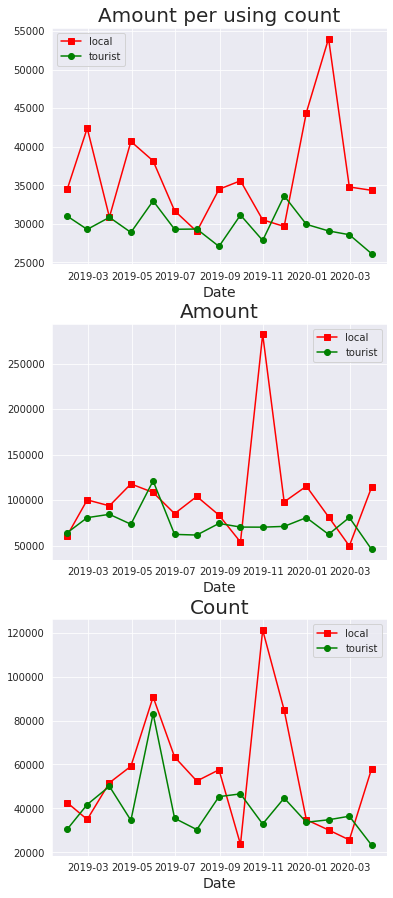

In [12]:
plt.subplot(311)
plt.plot(index, ts.lcl_amt_mean, marker='s', color='r')
plt.plot(index, ts.trst_amt_mean, marker='o', color='g')
plt.title('Amount per using count', fontsize=20) 
plt.xlabel('Date', fontsize=14)
plt.legend(['local','tourist'])

plt.subplot(312)
plt.plot(index, ts.lcl_amt, marker='s', color='r')
plt.plot(index, ts.trst_amt, marker='o', color='g')
plt.title('Amount', fontsize=20) 
plt.xlabel('Date', fontsize=14)
plt.legend(['local','tourist'])

plt.subplot(313)
plt.plot(index, ts.lcl_cnt, marker='s', color='r')
plt.plot(index, ts.trst_cnt, marker='o', color='g')
plt.title('Count', fontsize=20) 
plt.xlabel('Date', fontsize=14)
plt.legend(['local','tourist'])

plt.subplots_adjust(top=3, hspace=0.25)
plt.show()

### IV. 평가

**건당 이용금액** -> 한 번 소비할 때 얼마나 통 크게 소비하는지에 대한 지표  
<지역민>
- 2020년 1월 대비 2월에 대폭 감소
- 2020년 3월 코로나 여파로 소비심리가 더 위축될 줄 알았으나 최고치.(어디에 소비했는지 세세하게 들여다 볼 필요 O)
- 2019년 8월이 두 번째로 높다. 관광객과 비교했을 때 차이가 매우 크다. 돈을 써도 관광객이 더 통 크게 소비할 것 같은데 예상 밖이다.(이 달 역시 소비내역을 들여다 볼 필요 O)
- 2019년 11월이 최저치다.

<관광객>
- 2020년 1월이 두 번째로 높다. 그러나 코로나 여파 때문인지 2월부터 계속 하향세다.
- 2020년 3월에 지역민과 가장 큰 차이를 보인다.
- 2019년 11월이 최고치. 반면 지역민은 하락하는 것을 볼 수 있다.
</br>
</br>
---
**총 이용금액**  
<지역민>
- 2019년 10월 최고치. 관광객과 가장 큰 차이를 보인다.
- 2019년 5월과 2020년 1월에 큰 상승세를 보이다가 다음달에 바로 급하락한다.

<관광객>
- 2020년 1월 소비가 가장 높으나 다음달부터 계속 하락세
</br>
</br>
---
**총 이용건수**  
<지역민>
- 2019년 10월 11월이 가장 높다가 12월에 급하락
- 그 다음으로 2019년 5월이 가장 높으나 역시 6월에 급하락

<관광객>
- 총 이용금액과 비슷한 추이
---
- 코로나 여파로 인한 소비위축이 예상되는 2월과 3월을 볼 때,  
지역민은 총 이용금액과 총 거래건수에서  
2월은 전년 동월 대비 다소 위축된 소비를 보이지만  
3월에 오름세를 보이며, 전년 동월과 비교했을 때도 높은 수치다. 이것이 의문.  
관광객은  
큰 폭은 아니지만 작은 폭 감소된 것을 볼 수 있음
- 전반적으로 봤을 때 지역민은 들쑥날쑥한 소비 추세를 보이는 것으로 보아 계절성을 가지는 것으로 판단.
